In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exploring-predictive-health-factors/sample_submission.csv
/kaggle/input/exploring-predictive-health-factors/train.csv
/kaggle/input/exploring-predictive-health-factors/test.csv


# Reference: https://www.kaggle.com/code/swas06/pcosrandomforest

    Polycystic Ovary Syndrome (PCOS) is a common endocrine disorder among women of reproductive age. Early prediction of PCOS can help in effective treatment and management. 

    The ROC (Receiver Operating Characteristic) curve is a graphical representation of a classifier's performance, showing the trade-off between sensitivity (True Positive Rate) and specificity (False Positive Rate). 

    The area under the ROC curve (AUC) provides an aggregate measure of a model's performance across all classification thresholds.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Load datasets - train, test, submission

In [3]:
# Load data
train = pd.read_csv('/kaggle/input/exploring-predictive-health-factors/train.csv')
test = pd.read_csv('/kaggle/input/exploring-predictive-health-factors/test.csv')
sample_submission = pd.read_csv('/kaggle/input/exploring-predictive-health-factors/sample_submission.csv')

# Define and checking target and features

In [4]:
# Define target and features
target = 'PCOS'
features = [col for col in train.columns if col != target]

In [5]:
# Ensure target column is present in both datasets
if target not in train.columns:
    raise KeyError(f"Target column '{target}' not found in training data.")
if target not in test.columns:
    test[target] = np.nan  # Add target column to test if it's missing

In [6]:
# Ensure target column is binary (0 and 1)
train[target] = train[target].map({'Yes': 1, 'No': 0})
test[target] = test[target].map({'Yes': 1, 'No': 0})

In [7]:
# Split training data into features and target
X = train[features]
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# EDA: Correlation between PCOS and other variables

**Both train and test datasets**

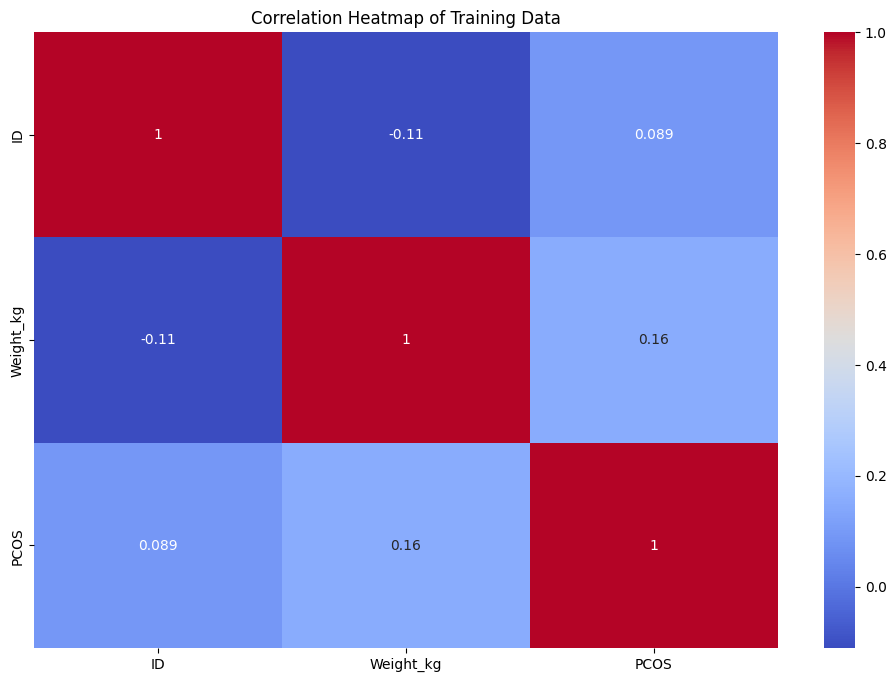

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


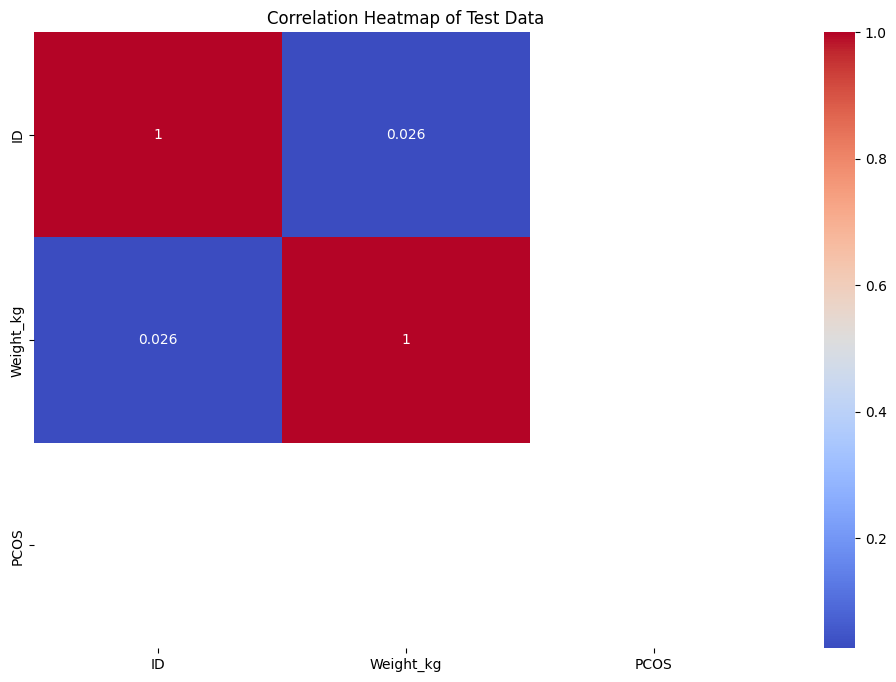

In [8]:
# EDA: Correlation between PCOS and other variables (only numeric columns)
plt.figure(figsize=(12, 8))
correlation = train.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Training Data')
plt.show()

plt.figure(figsize=(12, 8))
correlation_test = test.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(correlation_test, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Test Data')
plt.show()

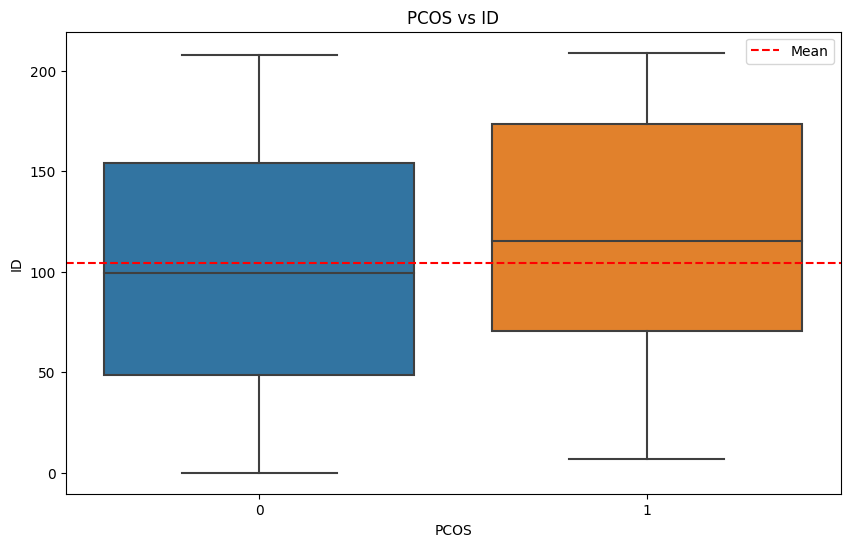

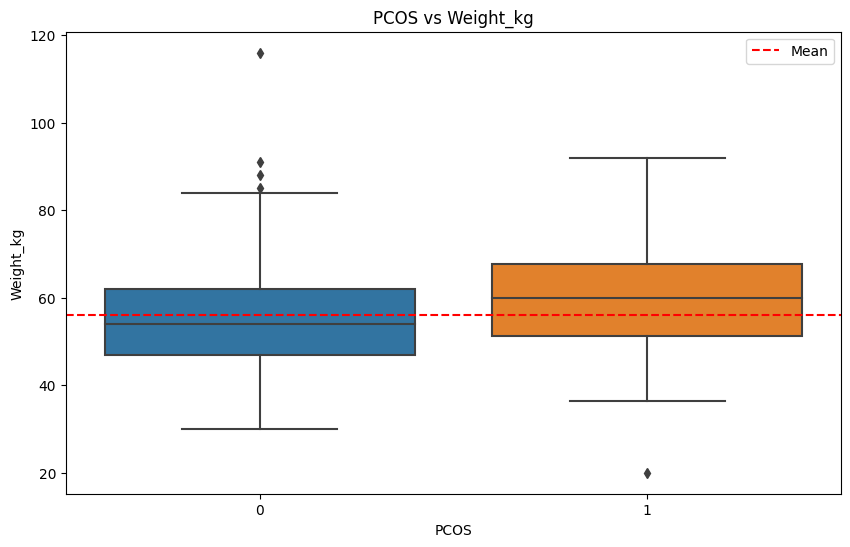

In [9]:
# Plot PCOS vs other variables (only numeric variables)
numeric_features = train[features].select_dtypes(include=['int64', 'float64']).columns
for col in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=train[target], y=train[col])
    plt.axhline(train[col].mean(), color='red', linestyle='--', label='Mean')
    plt.title(f'PCOS vs {col}')
    plt.legend()
    plt.show()

# Define pipelines

In [10]:
# Define pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

# Train models - logistic regression, random forest, and XGBoost

In [11]:
# Train models
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ID', 'Weight_kg'], dtype='object'))])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_sto...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# Evaluate models - logistic regression, random forest, and XGBoost

Logistic Regression Accuracy: 0.7857
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        33
           1       0.00      0.00      0.00         9

    accuracy                           0.79        42
   macro avg       0.39      0.50      0.44        42
weighted avg       0.62      0.79      0.69        42

Random Forest Accuracy: 0.7381
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        33
           1       0.00      0.00      0.00         9

    accuracy                           0.74        42
   macro avg       0.39      0.47      0.42        42
weighted avg       0.61      0.74      0.67        42

XGBoost Accuracy: 0.7381
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        33
           1       0.00      0.00      0.00         9

    accuracy                           0.74        42
   macro avg       0.39      0.47  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


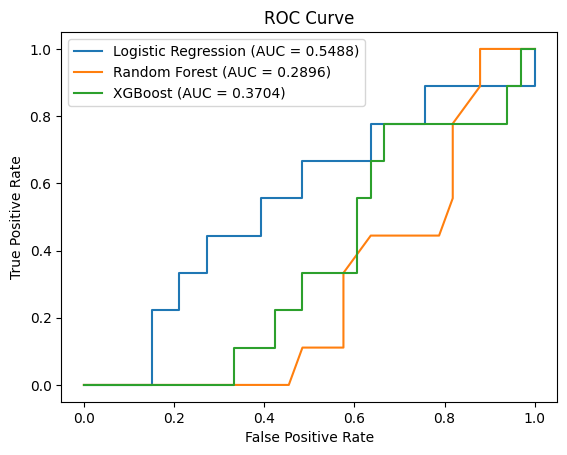

In [12]:
# Evaluate models
models = {'Logistic Regression': lr_pipeline, 'Random Forest': rf_pipeline, 'XGBoost': xgb_pipeline}
for name, model in models.items():
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(classification_report(y_val, y_val_pred))
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Make predictions on test data

In [13]:
# Make predictions on test data
y_test_pred = rf_pipeline.predict(test[features])

# Submission

In [14]:
submission_df = pd.read_csv('/kaggle/input/exploring-predictive-health-factors/sample_submission.csv')
submission_df[target] = y_test_pred
submission_df.to_csv('submission.csv', index=False)
print(submission_df.head())

   ID  PCOS
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0
